# 1. Evaluation of the Completeness of Data

In the initial phase of our predictive modeling project, it's crucial to assess the completeness of the data collected across various datasets. This evaluation ensures that the foundational data used for modeling is robust and reflective of real-world conditions, allowing for more accurate predictions and insights.

**Methodology**

In [2]:
import pandas as pd
import numpy as np

# Load datasets and evaluate missing values
data_files = {
    "cycles": "data/cycles.csv",
    "farms": "data/farms.csv",
    "fasting": "data/fasting.csv",
    "fastings": "data/fastings.csv",
    "feed_tray": "data/feed_tray.csv",
    "feeds": "data/feeds.csv",
    "harvests": "data/harvests.csv",
    "measurements": "data/measurements.csv",
    "mortalities": "data/mortalities.csv",
    "ponds": "data/ponds.csv",
    "samplings": "data/samplings.csv"
}

# Load each dataset into a dataframe
dataframes = {name: pd.read_csv(path) for name, path in data_files.items()}

# Calculate percentage of missing values and sort them
missing_values_summary = {
    name: (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    for name, df in dataframes.items()
}

# Display missing values summary, sorted by highest percentage
for dataset_name, missing_values in missing_values_summary.items():
    if not missing_values.empty:
        print(f"Missing Values in {dataset_name} Dataset:\n{missing_values}\n")
    else:
        print(f"No missing values in {dataset_name} Dataset.\n")


Missing Values in cycles Dataset:
ordered_at                58.196408
remark                    48.949178
species_id                31.104318
hatchery_id               17.768437
hatchery_name             17.768437
total_seed_type            9.247230
pond_depth                 4.508980
initial_age                1.834161
limit_weight_per_area      0.267482
pond_length                0.229270
pond_width                 0.229270
target_size                0.152847
target_cultivation_day     0.114635
finished_at                0.038212
id                         0.000000
total_seed                 0.000000
created_at                 0.000000
started_at                 0.000000
pond_id                    0.000000
updated_at                 0.000000
subscription_type          0.000000
extracted_at               0.000000
area                       0.000000
pond_name                  0.000000
dtype: float64

Missing Values in farms Dataset:
regency     16.878403
province    13.067151
id       

# 2. Calculate The Survival Rate of The Shrimps

In [3]:
#Survival Rate
def calculate_sr(cycles_df, harvests_df):
    # Handle duplicates in cycles_df
    cycles_df = cycles_df.drop_duplicates(subset=['id', 'total_seed'])

    # Calculate the total number of harvested shrimp using sum-product
    harvests_df['total_harvested_shrimp'] = harvests_df['weight'] * harvests_df['size']
    
    # Aggregate the harvests data by cycle_id using sum-product for total harvested shrimp
    aggregated_harvests_df = harvests_df.groupby('cycle_id').agg({
        'total_harvested_shrimp': 'sum'
    }).reset_index()
    
    # Merge the cycles data with the aggregated harvests data
    merged_df = pd.merge(cycles_df, aggregated_harvests_df, left_on='id', right_on='cycle_id', how='inner')
    
    # Calculate Survival Rate (SR)
    merged_df['SR'] = (merged_df['total_harvested_shrimp'] / merged_df['total_seed']) * 100
    
    return merged_df[['cycle_id', 'SR']]


sr_df = calculate_sr(dataframes['cycles'], dataframes['harvests'])
sr_df["cycle_id"] = sr_df['cycle_id'].astype(int).astype(str)
sr_df.to_csv('survival_rate.csv', index=False)
print("Survival Rate (SR) per Cultivation Cycle:\n", sr_df.head())



Survival Rate (SR) per Cultivation Cycle:
   cycle_id         SR
0    18876  46.953031
1    22118  74.250000
2    24088  52.193979
3    17743  69.962551
4    17125  14.856383


# 3. Average growth rate (ADG) of shrimp per cultivation cycle

In [4]:
import pandas as pd

def calculate_adg_from_samplings(samplings_df):
    samplings_df['sampled_at'] = pd.to_datetime(samplings_df['sampled_at'], errors='coerce', dayfirst=False)

    # Drop rows where dates could not be parsed (now NaT)
    samplings_df = samplings_df.dropna(subset=['sampled_at'])

    # Sort the DataFrame
    samplings_df = samplings_df.sort_values(by=['cycle_id', 'sampled_at'])
    
    # Calculate weight differences and the days between samplings
    samplings_df['weight_diff'] = samplings_df.groupby('cycle_id')['average_weight'].diff()
    samplings_df['days_diff'] = samplings_df.groupby('cycle_id')['sampled_at'].diff().dt.days

    # Calculate ADG for each interval
    samplings_df['interval_adg'] = samplings_df['weight_diff'] / samplings_df['days_diff']
    
    # Average the ADGs to get a single value per cycle
    adg_df = samplings_df.groupby('cycle_id')['interval_adg'].mean().reset_index()
    adg_df.columns = ['cycle_id', 'ADG']
    
    return adg_df


adg_df = calculate_adg_from_samplings(dataframes['samplings'])
print("Average Daily Gain (ADG) per Cultivation Cycle:\n", adg_df.head())
adg_df.to_csv('adg.csv', index=False)


Average Daily Gain (ADG) per Cultivation Cycle:
    cycle_id       ADG
0    3458.0  0.270260
1    3459.0  0.266786
2    4038.0  0.281250
3    4039.0  0.273077
4    4044.0  0.256103


# 4. Feature Engineering for Survival Rate Predictive Model

## 4. 1. Agregate The Environtmental Factor for Each Cycle, calculate the mean

In [5]:
# Access the measurements data from the dataframes dictionary
measurements = dataframes["measurements"]

# Group by 'cycle_id' and calculate mean for each numeric column, excluding NaNs
average_means = measurements.groupby('cycle_id').mean(numeric_only=True).reset_index()

average_means["cycle_id"] = average_means['cycle_id'].astype(str)


## 4.2. Number of Cultivation Days per Cycle

In [6]:
# Access the cycles data from the dataframes dictionary
cycles = dataframes["cycles"]
# Convert 'started_at' and 'finished_at' to datetime if not already
cycles['started_at'] = pd.to_datetime(cycles['started_at'])
cycles['finished_at'] = pd.to_datetime(cycles['finished_at'])

# Calculate the age of each cycle in days
cycles['cycle_age_days'] = (cycles['finished_at'] - cycles['started_at']).dt.days

# Display the updated DataFrame with cycle age
cycles_last = cycles.drop_duplicates(subset=['id'], keep='last')

cycles_last["id"] = cycles_last['id'].astype(str)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21416\2452845885.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycles_last["id"] = cycles_last['id'].astype(str)


## 4.3 Total Harvested Shrimp (Size) and Total Weight

In [7]:
harvests = dataframes["harvests"]

#Calculate the total harvested shrimp (sumproduct for each cycle_id)
harvests['total_harvested_shrimp'] = harvests['weight'] * harvests['size']

#Calculate the total shrimp and total weight per cycle_id
total_shrimp_per_cycle = harvests.groupby('cycle_id')['size'].sum()
total_weight_per_cycle = harvests.groupby('cycle_id')['weight'].sum()

#Merge the results back into the original dataframe 
harvests = harvests.merge(total_shrimp_per_cycle.rename('total_shrimp'), on='cycle_id', how='left')
harvests = harvests.merge(total_weight_per_cycle.rename('total_weight'), on='cycle_id', how='left')

# Display the dataframe with the required columns
harvests = harvests[["cycle_id", "total_shrimp", "total_weight"]]

# Remove duplicates 
harvests = harvests.drop_duplicates(subset=['cycle_id', "total_shrimp", "total_weight"])
harvests["cycle_id"] = harvests['cycle_id'].astype(int).astype(str)

# Display the final DataFrame
print(harvests.head())


  cycle_id  total_shrimp  total_weight
0    15013        399.86          0.01
1    11848        600.00         56.00
3     4666        300.00        541.00
5    18747         72.30       5322.28
6    27095        544.00       9382.50


## 4.4 Total Feed Quantity per Cycle

In [8]:
feeds = dataframes["feeds"]

# Group by cycle_id and sum the quantity
total_feed_per_cycle = feeds.groupby('cycle_id')['quantity'].sum().reset_index()
total_feed_per_cycle.rename(columns={'quantity': 'feed_quantity'}, inplace=True)
total_feed_per_cycle["cycle_id"] = total_feed_per_cycle['cycle_id'].astype(str)

## 4.5 Data Merging

In [9]:
sr_data_model = pd.merge(cycles_last, harvests ,left_on='id', right_on="cycle_id", how='left')
sr_data_model = pd.merge(sr_data_model, total_feed_per_cycle, on="cycle_id", how='left')
sr_model_dataf = pd.merge(sr_df,sr_data_model, on="cycle_id", how='left')
sr_model_dataf2= pd.merge(sr_model_dataf,average_means, on="cycle_id", how='left')

## 4.6 Filter Out The Data Based on Survival Rate < 100%

In [10]:
sr_model_dataf2 = sr_model_dataf2[sr_model_dataf2["SR"] < 100]

## 4.7 Feature Selection for Modeling

In [11]:
sr_model_dataf3= sr_model_dataf2[["SR", "cycle_age_days", "total_seed","area","total_shrimp", "total_weight",
                                 "feed_quantity", "morning_temperature","evening_temperature", "morning_do", "evening_do",
                                 "morning_salinity", "evening_salinity", "morning_pH", "evening_pH",
                                 "nitrate", "nitrite", "alkalinity"]]

# 5. Modeling for Survival Rate

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import numpy as np  # Import numpy for the square root function

sr_model_datafinal = sr_model_dataf3.fillna(sr_model_dataf3.median())

X = sr_model_datafinal[["cycle_age_days", "total_seed","area","total_shrimp", "total_weight",
                        "feed_quantity", "morning_temperature","evening_temperature", "morning_do", "evening_do",
                        "morning_salinity", "evening_salinity", "morning_pH", "evening_pH",
                        "nitrate", "nitrite", "alkalinity"]]

y = sr_model_datafinal["SR"]

# Split the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)  
model.fit(X_train, y_train)
joblib.dump(model, 'model_sr.pkl')

# Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate the root mean squared error
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")  # Output RMSE
print(f"R-squared: {r2}")

model = joblib.load('model_sr.pkl')

# Prepare the data (exclude any columns not used in training, such as cycle_id)
X_new = sr_model_dataf2[["cycle_age_days", "total_seed","area","total_shrimp", "total_weight",
                         "feed_quantity", "morning_temperature","evening_temperature", "morning_do", "evening_do",
                         "morning_salinity", "evening_salinity", "morning_pH", "evening_pH",
                         "nitrate", "nitrite", "alkalinity"]]

# Make predictions
predictions = model.predict(X_new)

# Combine predictions with the original sr_model_dataf2 (e.g., to include cycle_id or other identifiers)
sr_model_dataf2['predicted_SR'] = predictions

# Display the predictions
predicted_survival_rate = sr_model_dataf2[['cycle_id', 'predicted_SR']] 

predicted_survival_rate.to_csv("predicted_survival_rate.csv")

Mean Squared Error: 136.39641825706053
Root Mean Squared Error: 11.678887714892225
R-squared: 0.8131022587579652


# 6. Feature Importance for Survival Rate

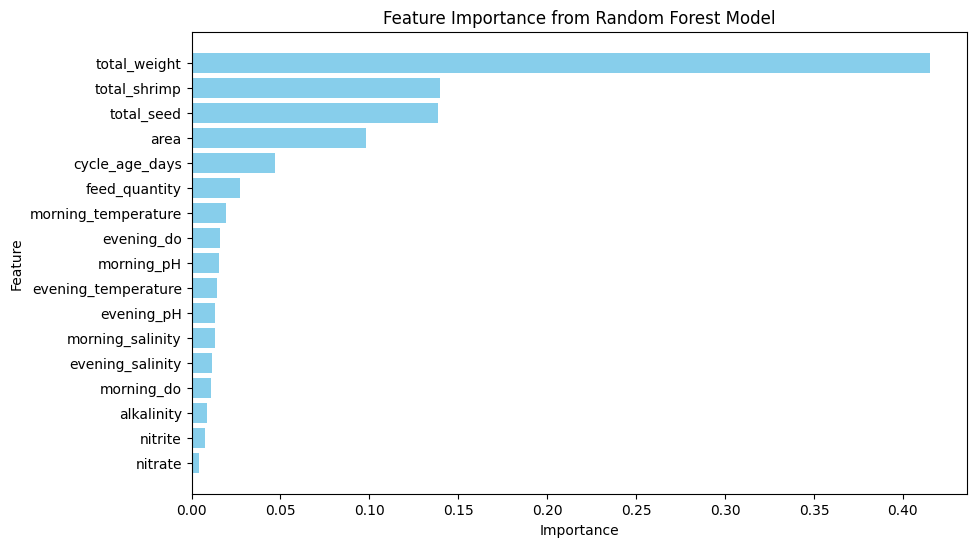

                Feature  Importance
4          total_weight    0.415038
3          total_shrimp    0.139814
1            total_seed    0.138793
2                  area    0.098363
0        cycle_age_days    0.047068
5         feed_quantity    0.027083
6   morning_temperature    0.019610
9            evening_do    0.016026
12           morning_pH    0.015194
7   evening_temperature    0.014341
13           evening_pH    0.013054
10     morning_salinity    0.013012
11     evening_salinity    0.011302
8            morning_do    0.011138
16           alkalinity    0.008543
15              nitrite    0.007442
14              nitrate    0.004178


In [14]:
import matplotlib.pyplot as plt

features = ["cycle_age_days", "total_seed", "area", "total_shrimp", "total_weight",
            "feed_quantity", "morning_temperature", "evening_temperature", "morning_do", "evening_do",
            "morning_salinity", "evening_salinity", "morning_pH", "evening_pH",
            "nitrate", "nitrite", "alkalinity"]

# Extract feature importances from the model
importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

# Display the DataFrame
print(feature_importance_df)


# 7. Feature Engineering for Average Body Weight of Shrimp (in grams) forecast

In [15]:
# Ensure dates are in the correct format
dataframes["samplings"]['sampled_at'] = pd.to_datetime(dataframes["samplings"]['sampled_at'])
dataframes["cycles"]['started_at'] = pd.to_datetime(dataframes["cycles"]['started_at'])

# Rename 'id' to 'cycle_id' in the cycles DataFrame for consistent merging
dataframes["cycles"].rename(columns={'id': 'cycle_id'}, inplace=True)

# Merge cycles data with samplings to get the start dates and average_weight for each cycle
merged_data = pd.merge(dataframes["samplings"], dataframes["cycles"][['cycle_id', 'started_at']],
                       on='cycle_id', how='left')

# Calculate the age in days at each sampling point
merged_data['age_at_sampling_days'] = (merged_data['sampled_at'] - merged_data['started_at']).dt.days


# Merge df1 and df2 using 'id' and matching 'name' from df1 with 'full_name' from df2
dataframes["feeds"]['logged_at'] = pd.to_datetime(dataframes["feeds"]['logged_at']).dt.date
dataframes["samplings"]["sampled_at"] = pd.to_datetime(dataframes["feeds"]['logged_at']).dt.date
merged_data["sampled_at"] = pd.to_datetime(merged_data['sampled_at']).dt.date

# Drop duplicates, keeping only the last occurrence in df1
df1_last = dataframes["feeds"].drop_duplicates(subset=['cycle_id', 'logged_at'], keep='last')

result = pd.merge(merged_data, df1_last, left_on=['cycle_id', 'sampled_at'], right_on=['cycle_id', 'logged_at'], how='left')

result["cycle_id"] = result['cycle_id'].astype(int).astype(str)

result2 = pd.merge(result, sr_model_dataf2, on=['cycle_id'], how='left')

abw_model_datafinal = result2[["age_at_sampling_days", "total_seed", "area", "total_shrimp", "total_weight",
            "feed_quantity", "morning_temperature", "evening_temperature", "morning_do", "evening_do",
            "morning_salinity", "evening_salinity", "morning_pH", "evening_pH",
            "nitrate", "nitrite", "alkalinity","average_weight"]]

# 8. Modeling for Average Body Weight of Shrimp (in grams) forecast

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import numpy as np

# Assume 'abw_model_datafinal' is your DataFrame and is already loaded

# Fill missing values
abw_model_datafinal = abw_model_datafinal.fillna(abw_model_datafinal.median())

# Define features and target
X = abw_model_datafinal[["age_at_sampling_days", "area", "feed_quantity"]]
y = abw_model_datafinal["average_weight"] * 1000  # Convert target from kg to grams

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor model
model_abw = RandomForestRegressor(n_estimators=100, random_state=42)
model_abw.fit(X_train, y_train)

# Save the trained model
joblib.dump(model_abw, 'model_abw.pkl')

# Evaluate the model
y_pred = model_abw.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate the root mean squared error
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

model_abw = joblib.load('model_abw.pkl')

# Prepare the data (same features used during training)
X_new = result2[["age_at_sampling_days", "area", "feed_quantity"]]

# Make predictions
predictions = model_abw.predict(X_new)

# Convert predictions back from grams to kg (if needed)
predictions_g = predictions   # Convert grams back to kg

# Combine predictions with the original abw_model_dataf2 (e.g., to include cycle_id or other identifiers)
result2['predicted_average_weight_g'] = predictions_g

# Display the predictions
predited_average_shrimp_per_gram = result2[['cycle_id', "age_at_sampling_days",'predicted_average_weight_g']]

predited_average_shrimp_per_gram.to_csv("predited_average_shrimp_per_gram.csv")

Mean Squared Error: 8143140.954969159
Root Mean Squared Error: 2853.6189225208677
R-squared: 0.854488354572283


# 9. Feature Importance for Average Body Weight

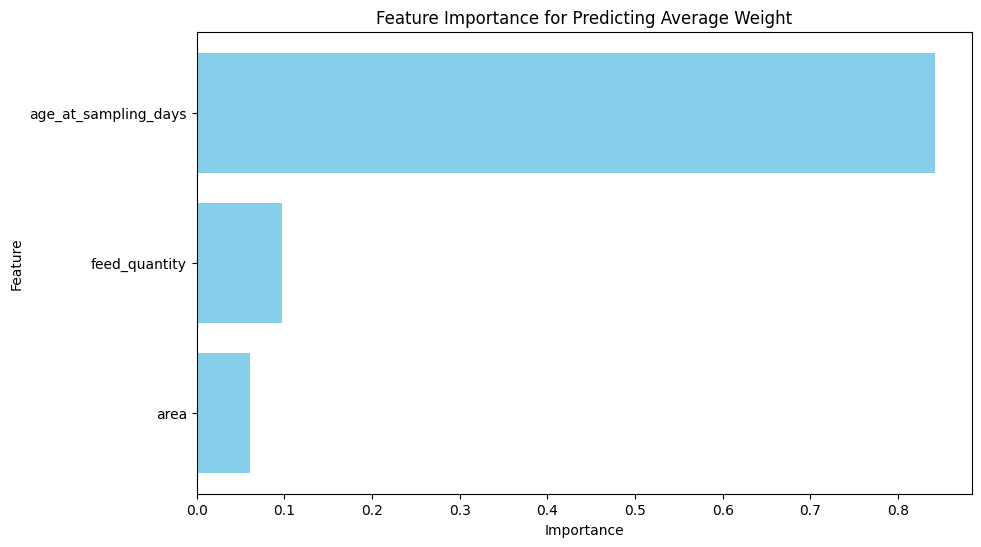

                Feature  Importance
0  age_at_sampling_days    0.842102
2         feed_quantity    0.096748
1                  area    0.061150


In [17]:
# Calculate feature importances
feature_importances = model_abw.feature_importances_
features = ["age_at_sampling_days", "area", "feed_quantity"]
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Predicting Average Weight')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

# Print the DataFrame of feature importances
print(feature_importance_df)

# 10. Biomass Forecast

c:\Users\lenovo\Documents\jalaku\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


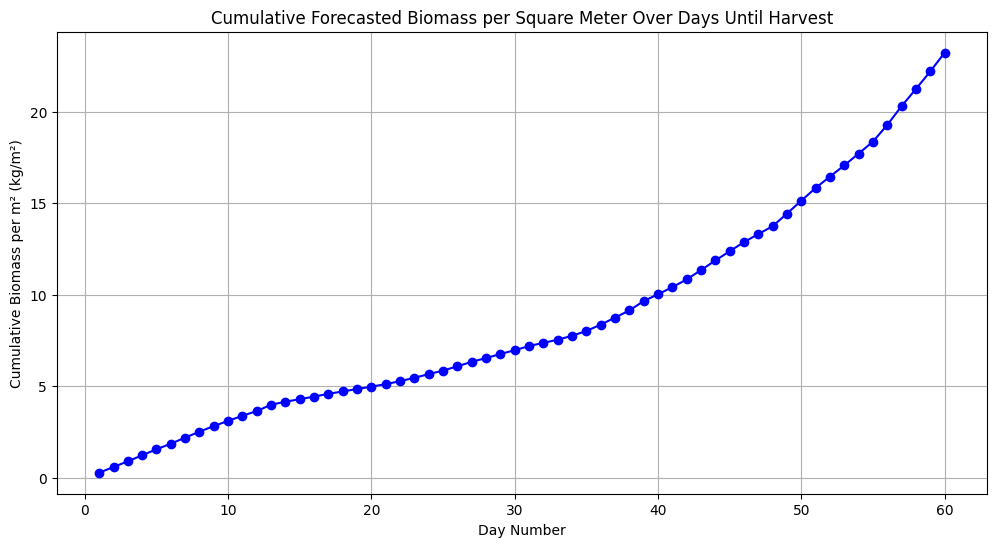

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

def forecast_biomass(days_until_harvest, pond_area, total_seed, feed_quantity):
    # Load the pre-trained RandomForestRegressor model
    model = load('model_abw.pkl')  # Ensure the model file 'model_abw.pkl' is in your directory

    # Generate daily data for the specified number of days until harvest
    day_numbers = np.arange(1, days_until_harvest + 1)  # Day numbers from 1 to days_until_harvest
    feed_quantity_array = np.full(days_until_harvest, feed_quantity)  # Constant feed quantity each day
    pond_area_array = np.full(days_until_harvest, pond_area)  # Constant pond area

    # Prepare the features array for prediction
    X_predict = np.column_stack((day_numbers, pond_area_array, feed_quantity_array))

    # Predict ABW for each day (predictions are in grams)
    abw_predictions_grams = model.predict(X_predict)

    # Convert predictions to kilograms
    abw_predictions_kg = abw_predictions_grams / 1000

    # Calculate daily biomass in kg (assuming all seeds survive to each day)
    daily_biomass_kg = abw_predictions_kg * total_seed

    # Calculate cumulative biomass in kg
    cumulative_biomass_kg = np.cumsum(daily_biomass_kg)  # Cumulative sum of biomass

    # Calculate cumulative biomass per square meter
    cumulative_biomass_per_m2 = cumulative_biomass_kg / pond_area

    # Create a DataFrame for plotting
    forecast_df = pd.DataFrame({
        'Day': day_numbers,
        'Cumulative_Biomass_per_m2': cumulative_biomass_per_m2
    })

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_df['Day'], forecast_df['Cumulative_Biomass_per_m2'], marker='o', linestyle='-', color='blue')
    plt.title('Cumulative Forecasted Biomass per Square Meter Over Days Until Harvest')
    plt.xlabel('Day Number')
    plt.ylabel('Cumulative Biomass per m² (kg/m²)')
    plt.grid(True)
    plt.show()

# Example usage of the function
forecast_biomass(days_until_harvest=60, pond_area=1000, total_seed=100, feed_quantity=1200)


# 11. Revenue Forecast

In [19]:
import numpy as np
from joblib import load

def forecast_biomass_and_revenue(days_until_harvest, pond_area, total_seed, feed_quantity, price_per_kg):
    # Load the pre-trained model
    model = load('model_abw.pkl')

    # Generate daily data
    day_numbers = np.arange(1, days_until_harvest + 1)
    feed_quantity_array = np.full(days_until_harvest, feed_quantity)
    pond_area_array = np.full(days_until_harvest, pond_area)

    # Predict ABW for each day using the model (in grams)
    X_predict = np.column_stack((day_numbers, pond_area_array, feed_quantity_array))
    abw_predictions_grams = model.predict(X_predict)

    # Convert predictions to kilograms
    abw_predictions_kg = abw_predictions_grams / 1000

    # Calculate daily biomass in kg
    daily_biomass_kg = abw_predictions_kg * total_seed

    # Calculate cumulative revenue
    daily_revenue = daily_biomass_kg * price_per_kg
    cumulative_revenue = np.cumsum(daily_revenue)

    # Print cumulative revenue on the last day
    print(f"Cumulative Revenue by Day {days_until_harvest}: ${cumulative_revenue[-1]:.2f}")

    return cumulative_revenue[-1]

# Example usage
price_per_kg = 10  # Example price per kilogram of shrimp
forecasted_revenue = forecast_biomass_and_revenue(days_until_harvest=60, pond_area=1000, total_seed=100, feed_quantity=1200, price_per_kg=price_per_kg)


Cumulative Revenue by Day 60: $232171.74


c:\Users\lenovo\Documents\jalaku\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
